<a href="https://colab.research.google.com/github/Atta-UR/Image_Classification_on_Cifar10_Dataset/blob/main/Image_Classification_Using_Cifar10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries Including the Dataset

In [1]:
# Importing TensorFlow and Keras libraries for building and training neural networks
import tensorflow as tf
from tensorflow.keras.datasets import cifar10  # CIFAR-10 dataset for image classification
from tensorflow.keras.models import Sequential  # Sequential model for stacking layers linearly
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Layers for CNN construction
from tensorflow.keras.layers import Input  # Import the Input layer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation and Image Pre-procssing
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adamax # Optimizer
# Libraries for data visualization and numerical operations
import matplotlib.pyplot as plt  # Used to visualize training progress and augmented images
import numpy as np  # Essential for numerical operations and array manipulation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50


# Load and Preprocess the CIFAR-10 Data

In [2]:
def preprocess_cifar10():
    """
    Load the CIFAR-10 dataset, normalize the images to a range of 0-1,
    and one-hot encode the labels. Additionally, split the test dataset
    into validation and testing sets.

    Returns:
        tuple: Processed training, validation, and testing data.
               (x_train, y_train), (x_val, y_val), (x_test, y_test)
    """
    # Load CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize image data to range [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # One-hot encode labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Split test data into validation and test sets
    x_val, x_test, y_val, y_test = train_test_split(
        x_test, y_test, test_size=0.5, random_state=42
    )

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(x_train, y_train), (x_val, y_val), (x_test, y_test) = preprocess_cifar10()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


# Data Augmentation

In [3]:
# Create an instance of the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,          # Randomly rotate images within a range of 15 degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,     # Randomly shift images vertically by 10% of the height
    horizontal_flip=True,       # Randomly flip images horizontally
    zoom_range=0.1              # Randomly zoom in on images by up to 10%
)

# Fit the data generator on the training dataset to calculate statistics
# (e.g., mean, std) required for certain normalization techniques.
datagen.fit(x_train)

# Visualize Sample Augmented Images

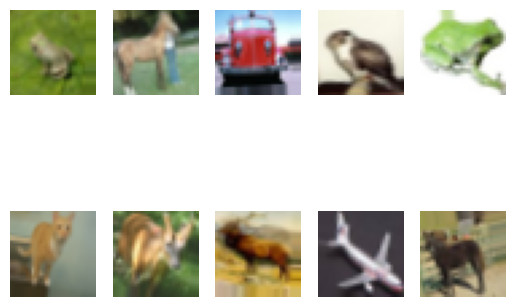

In [4]:
# Display augmented images
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=10):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()
    break  # Display one batch and stop

# Simple CNN Model With 5X5 Kernal Size

In [5]:
# Define the CNN model architecture with reduced complexity and 5x5 kernel size
model = Sequential([
    Input(shape=(32, 32, 3)),                      # Explicitly define the input shape

    # Block 1: Conv2D + BatchNormalization + MaxPooling + Dropout
    Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2: Conv2D + BatchNormalization + MaxPooling + Dropout
    Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3: Conv2D + BatchNormalization + MaxPooling + Dropout
    Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully connected layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])


# Compiling the Model

In [6]:
# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 787,658 (3.00 MB)

 Trainable params: 786,698 (3.00 MB)

 Non-trainable params: 960 (3.75 KB)

# Training the Model

In [7]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)                          # Reduce learning rate
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(x_val, y_val),              # Validation data
    callbacks=callbacks                            # Add callbacks
)
model.save('/content/drive/MyDrive/simple_model.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 59ms/step - accuracy: 0.2867 - loss: 7.3782 - val_accuracy: 0.4558 - val_loss: 4.3016 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.4390 - loss: 3.9389 - val_accuracy: 0.4240 - val_loss: 3.0412 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.5209 - loss: 2.5411 - val_accuracy: 0.4774 - val_loss: 2.4453 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.5668 - loss: 1.9677 - val_accuracy: 0.6208 - val_loss: 1.6797 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5970 - loss: 1.7040 - val_accuracy: 0.5470 - val_loss: 1.7424 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 49ms/step - accuracy: 0.6270 - loss: 1.5510 - val_accuracy: 0.6316 - val_loss: 1.5942 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.6423 - loss: 1.4709

# Training Curves

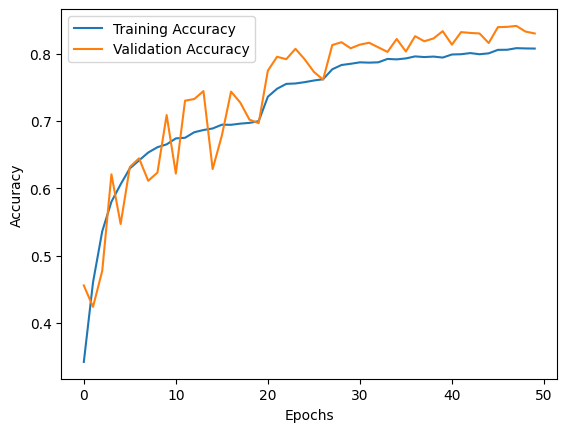

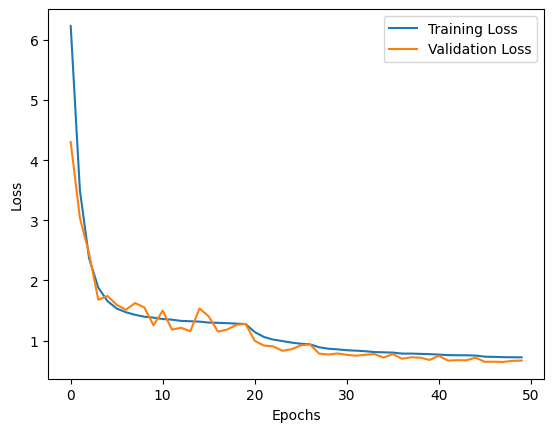

In [8]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Define the CNN Model

In [9]:
# Define the CNN model architecture with 10 Conv2D layers
model = Sequential([
    Input(shape=(32, 32, 3)),                      # Explicitly define the input shape

    # Block 1: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4: 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 5: 2 Conv2D layers (10th Conv2D added here) + BatchNormalization + MaxPooling + Dropout
    Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compiling the Model

In [10]:
# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model

In [11]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)                          # Reduce learning rate
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(x_test, y_test),              # Validation data
    callbacks=callbacks                            # Add callbacks
)

model.save('/content/drive/MyDrive/CNN_with_more _Layers_model.h5')

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 86ms/step - accuracy: 0.2306 - loss: 28.6404 - val_accuracy: 0.3136 - val_loss: 14.1675 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - accuracy: 0.4214 - loss: 11.2222 - val_accuracy: 0.4362 - val_loss: 5.5256 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.4891 - loss: 4.5189 - val_accuracy: 0.4662 - val_loss: 3.2281 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.5384 - loss: 2.5730 - val_accuracy: 0.5302 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.5764 - loss: 2.0567 - val_accuracy: 0.5472 - val_loss: 2.0237 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.6109 - loss: 1.8396 - val_accuracy: 0.4764 - val_loss: 2.1817 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.6315 

# Visualize Training History

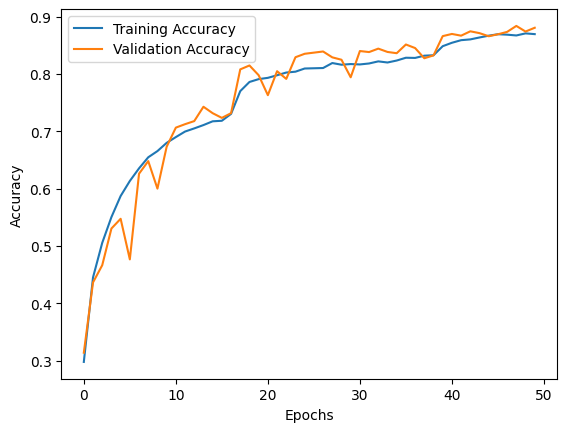

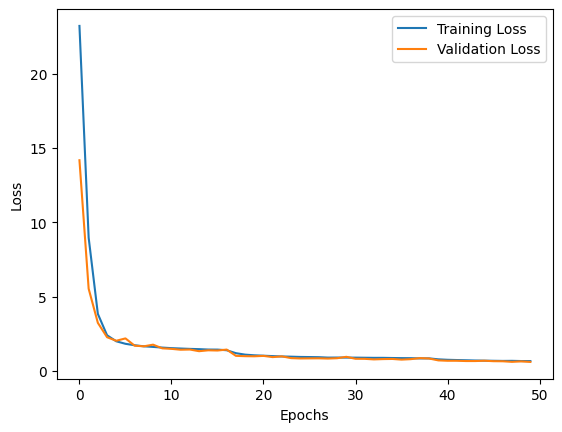

In [12]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Evaluation

# Importing Pretrained VGG 16 Model

In [14]:
def build_vgg16_model():
    """
    Build a VGG16-based model for CIFAR-10 dataset.

    Returns:
        model: A compiled Keras model.
    """
    # Load the VGG16 model without the top layer
    base_model = VGG16(include_top=False, input_shape=(32, 32, 3), weights=None)

    # Create the model
    model = Sequential([
        base_model,  # Pre-trained VGG16 base
        Flatten(),  # Flatten the output of the VGG16 base
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Training the VGG16 Model

In [15]:
# Build the model
model = build_vgg16_model()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
     ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)
]

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)
model.save('/content/drive/MyDrive/VGG16_model.h5')

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=vgg16_cifar10_best_model.h5

# Evaluating the VGG16 Model

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Importing Resnet50 Model

In [ ]:
def build_resnet50_model():
    """
    Build a ResNet50-based model for CIFAR-10 dataset.

    Returns:
        model: A compiled Keras model.
    """
    # Load the ResNet50 model without the top layer
    base_model = ResNet50(include_top=False, input_shape=(32, 32, 3), weights=None)

    # Create the model
    model = Sequential([
        base_model,  # Pre-trained ResNet50 base
        Flatten(),  # Flatten the output of the ResNet50 base
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Training the Resnet50 Model

In [ ]:
model = build_resnet50_model()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
     ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)
]

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

model.save('/content/drive/MyDrive/Resnet50_model.h5')

# Evaluating the Model

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")